# BM 336546 - HW1: Fetal Cardiotocograms 
# Part I: Data Exploration

In this homework you will be working on predicting fetal outcomes from continuous labor monitoring using Cardiotography (CTG). In particular you will use measures of the fetal heart rate (FHR) and use these as input features to your linear classifier. Before we dive into the assignment itself, let's make a quick introduction to CTG and get familiar with this type of examination and its underlying physiological basis as a good biomedical engineer!

Intrapartum CTG is used routinely to measure maternal uterine pressure and fetal heart rate (FHR). Antepartum CTG monitoring is used to identify fetuses at risk of intrauterine hypoxia and acidaemia. As early as 28 weeks of gestation, analysis of the FHR trace is used as a nonstress test to assess the fetal well-being. In the perinatal period, timely, appropriate intervention can avoid fetal neurological damage or death. The CTG is visually assessed by a clinician or interpreted by computer analysis. In the context of labor monitoring, the CTG is used for continuous fetal monitoring. An abnormal heart rate will lead the clinician to perform a cesarean. We will focus on CTG monitoring during labor in this assignment.

The CTG has two different transducers: One of them is a transducer placed on the mother’s abdomen, above the fetal heart, to monitor heart rate using Doppler probe (cardiogram). The other is located at the fundus of the uterus to measure frequency of contractions (tocogram). Tocodynamometry is a strain gauge technology provides contraction frequency and approximate duration of labor contractions.

We can extract a lot of features from a CTG. Here are some of them:
* **Uterine activity**: Duration, frequency and intensity of contractions.
* **Baseline FHR**: Mean FHR rounded to increments of 5 beats per minute (bpm) during a 10-minute window.
* **Baseline FHR variability**: Fluctuations in the baseline FHR that are irregular in amplitude and frequency.
* **Presence of accelerations**: A visually apparent abrupt increase in fetal heart rate.

Here is an example of a typical CTG with some of its features:

![img](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/6ed5ef1da100ebc2241c3a3945e1da9ce79f73ac/1-Figure1-1.png)

The CTG dataset is an Excel file which was sent to you. For more information, please look at the Excel sheet called Description or take a look at this [link](http://archive.ics.uci.edu/ml/datasets/Cardiotocography). Our main goal in this assignment is to train an algorithm to decide what is the fetal state according to the extracted features. Before we even start dealing with the data itself, we should apply the first and most important rule of data/signal processing: **ALWAYS LOOK AND UNDERSTAND THE DATA FIRST!**

In order to do that, we will load the file into a variable called CTG_features and use descriptive statistics and visualization tools you have seen in the lectures.


In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

file = Path.cwd().joinpath('messed_CTG.xls') # concatenates messed_CTG.xls to the current folder that should be the extracted zip folder 
CTG_dataset = pd.read_excel(file, sheet_name='Raw Data')
CTG_features = CTG_dataset[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DR', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']]
CTG_morph = CTG_dataset[['CLASS']]
fetal_state = CTG_dataset[['NSP']]

First  look at the data in your Excel file. You can see that in some of the cells we have '--' or NaN etc. Furthermore, the description tells us that the feature `DR` was removed although we did load it into our dataset. Your first job is: Implement the function `rm_ext_and_nan` in the module  `clean_data` so it will remove the extra feature `DR` (ignore the feature), and all non-numeric values (ignore the samples). This function should return a dictionary of features where the values of each feature are the clean excel columns without the `DR` feature. **Hint**: In order to eliminate every cell that is non-numeric, you will have to transform it first to NaN and only then eliminate them. **Note**: `CTG_dataset` is a `pandas DataFrame` and every element within it is called `pandas series`. Implement the function in a single line of code using dictionary comprehensions.

In [2]:
from clean_data import rm_ext_and_nan as rm
extra_feature = 'DR' 
c_ctg = rm(CTG_features, extra_feature)

Compare and make sure that your function works well: let's compare the histograms' width feature . First we will plot the original distribution of this feature where every NaN element was replaced by a value that is not reasonable as 1000 :

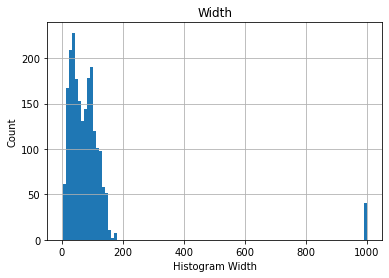

In [3]:
import matplotlib.pyplot as plt
feat = 'Width'
Q = pd.DataFrame(CTG_features[feat])
idx_na = Q.index[Q[feat].isna() == True].tolist()
for i in idx_na:
    Q.loc[i] = 1000
Q.hist(bins = 100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

Now run the following lines of code to check how you performed:

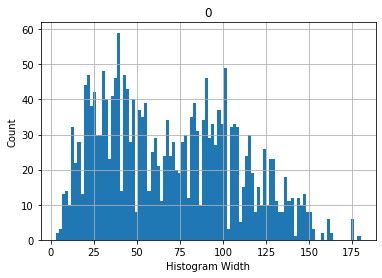

In [4]:
feat = 'Width'
Q_clean = pd.DataFrame(c_ctg[feat])
Q_clean.hist(bins=100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

Now that we are warmed up, let's do something a bit different. Instead of removing the NaN values, handle those missing values using sampling (**Tutorial C02**). Again, first convert all non-numeric values to NaN and only then apply the sampling method. Implement the function `nan2num_samp`. Don't forget to remove `DR` again.

In [5]:
from clean_data import nan2num_samp
extra_feature = 'DR' 
c_samp = nan2num_samp(CTG_features, extra_feature)

Now run the following lines of code to check how you performed for example with the feature `MSTV`:

In [6]:
feat = 'MSTV'
print(CTG_features[feat].iloc[0:5]) # print first 5 values
print(c_samp[feat].iloc[0:5])

0    NaN
1     --
2     --
3    2.1
4    2.4
Name: MSTV, dtype: object
0    2.2
1    0.5
2    1.4
3    2.1
4    2.4
Name: MSTV, dtype: Float64


Let's visualize our "clean" data using histograms, barplots and boxplots and then refer to the following questions below.

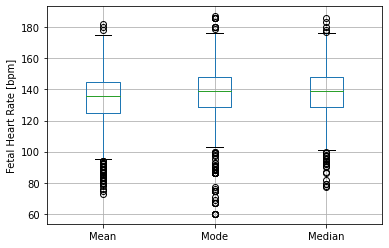

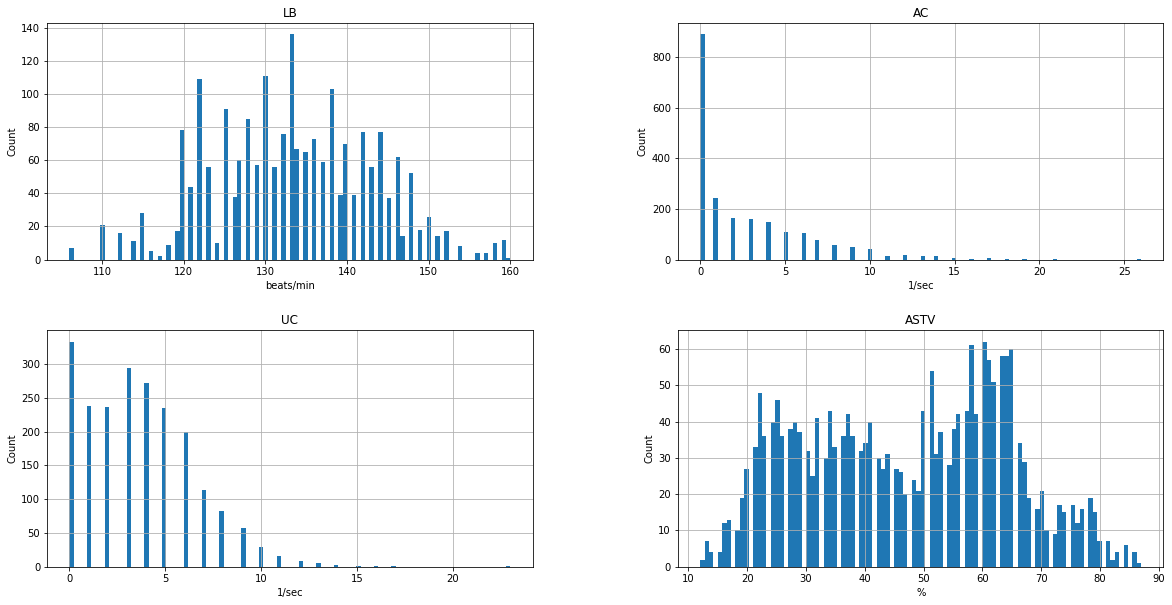

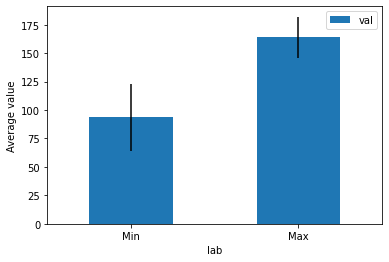

In [7]:
# Boxplots

c_samp.boxplot(column=['Mean','Mode', 'Median'])
plt.ylabel('Fetal Heart Rate [bpm]')
# Histograms
xlbl = ['beats/min','1/sec','1/sec','%']
axarr = c_samp.hist(column=['LB', 'AC', 'UC','ASTV'], bins=100,layout = (2, 2),figsize=(20, 10))
for i,ax in enumerate(axarr.flatten()):
    ax.set_xlabel(xlbl[i])
    ax.set_ylabel("Count")
# Barplots (error bars)
df = pd.DataFrame.from_dict({'lab':['Min','Max'], 'val':[np.mean(c_samp['Min']), np.mean(c_samp['Max'])]})
errors = [np.std(c_samp['Min']), np.std(c_samp['Max'])] 
ax = df.plot.bar(x='lab', y='val', yerr=errors, rot=0)
ax.set_ylabel('Average value')
plt.show()

**Remarks**: 
* Please answer all of the following questions within the notebook itself. Remember that the only files you will submit are the notebook and the fully-implemented `.py` files.
* Do not change the notebook's cells unless you were specificly told to (such as the "Answers" cells etc.). 

### Questions:
**Q1:** What information can you get from histograms and what information can you get from boxplots?

**Q2:** Error bars can be misleading. In what sense?

### Answers:
**Q1:**

Boxplot - We can get statistical information like median and quantiles. In addition, we can see the outliers.

Histogram - We can see easily the data distribution and the abnormalities. 

**Q2:**

There are many different types of error bars and if the figure legend does not state their exact type it can be misleading.


Now that we have visualized  the data, cleaned them and obtained some insights from them, we would like to compute the summary statistics for each feature. Implement the `sum_stat` function which returnes a dictionary of dictionaries, meaning that a key value of a feature will return a dictionary with keys of min, Q1, median, Q3, max.
It should look something like this:

d_summary = {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"MSTV": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": 2.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": 3.0,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": 4.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": 5.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": 6.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"LB": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": ...,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;}<br>
<br> 
You can access with : d_summary["MSTV"]["min"] = 2.0

You can use that output in order to have another cleanup and this time, it will be a cleanup of outliers. We will stick to the definition of an outlier according to the five number summary that are actually represented by boxplots. Just as a reminder and comparison to a normal distribution, have a look at the next figure:




<img src="https://miro.medium.com/max/1400/1*NRlqiZGQdsIyAu0KzP7LaQ.png" width="400">

In [8]:
from clean_data import sum_stat as sst
d_summary = sst(c_samp)
print(d_summary['MSTV'])

{'min': 0.2, 'Q1': 0.7, 'median': 1.2, 'Q3': 1.7, 'max': 7.0}


Implement the function `rm_outlier` that will have the output of `sum_stat` as an input and will return a DataFrame of the that will have outliers removed. In order to avoid issues of different lengths of entries, instead of removing the outliers, simply replace them with `np.nan`.

In [9]:
from clean_data import rm_outlier
c_no_outlier = rm_outlier(c_samp, d_summary)

Let's take the features `Median`, `Mean` and `Mode` for comparioson previous to outliers removal and after it using boxplots. First we plot the original data:

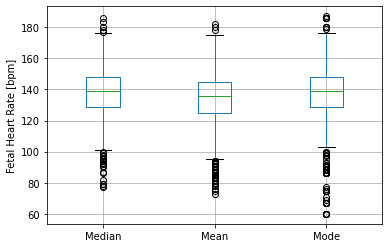

In [10]:
c_samp.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

Now we plot the "clean data":

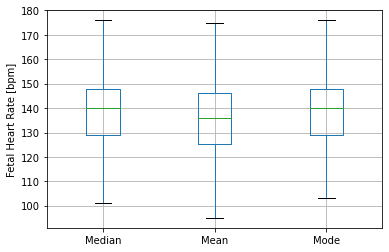

In [11]:
c_no_outlier.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

### Questions:
**Q3:** Boxplotting the data after the outliers were removed shows us that there are no outliers anymore. Is it necessarily always the case, meaning if you take the "clean" data and boxplot it again will it have no outliers for sure?

### Answers:
**Q3:** 

No, it is not always the case. 

When we remove the outliers the quantiles are changing, so when we calculate the borders again (Q1-1.5*(Q3-Q1) & Q3+1.5*(Q3-Q1)) they are changing as well - we will have other outliers, even though we wanted to have a plot without outliers.

Now, there is one more thing that should be reminded in the aspect of data exploration and it is the second rule of this field that states the following: **USE COMMON SENSE!**

What it really means is that if you have some physiological prior (e.g. you know the range of values of your features), so you should have some sanity checks. For example, the feature `LB` tells us about the FHR baseline. It won't make any sense if we found values that are higher than 500 bpm, not even mentioning non-positive values. Your next mission is to implement the function `phys_prior` where you choose one feature (which is not `LB`), explain what you think it's normal range is and clean it accordingly. The function will have `c_samp`, the feature that you chose and a threshold as inputs. The explanation should be written shortly as a comment next to the input as you can see at the following cell. The only lines you can change here are the `feature` value, the `thresh` value and its comment.

In [12]:
from clean_data import phys_prior as phpr
feature = 'UC'
'''
We chose the feature UC. 
There should be 3 to 5 contractions in the 10-minute window, 
which means max of 15 contractions in 30-minutes.
'''
thresh = 15
filt_feature = phpr(c_samp, feature, thresh)

## Data Scaling: Standardization and Normalization

By this point you have successfully cleaned your dataset, well done! The clean dataset was saved in pickle format called `objs.pkl`.

In [13]:
import pickle

with open('objs.pkl', 'rb') as f:
    CTG_features, CTG_morph, fetal_state = pickle.load(f)
orig_feat = CTG_features.columns.values

Now we will address an important step in data science which is called feature scaling. Here we will discuss about standardization and normalization. As you saw in the lectures, scaling enables us to prepare features that take their value in different ranges and map them to a “normalized” features that take their values in similar ranges.
Implement the methods of the class `NSD`. The `transform` method function will return the data normalized/standardized according to the mode. You should also choose two features for comparison (using histograms) between the original data and the different modes. Use `matplotlib` as you saw in your tutorials. The argument `flag` is used for visibility of histograms.  There are three types of `mode`: `'standard','MinMax' and 'mean'` as shown in the lecture. You may change `selected_feat` in the next cell if youl'd like to see that your implemetations apply well on other features as well.


**Notice:**

1. `fit` method should calculate all needed values for all possible modes. The mode is chosen only in `transform` (or `fit_transform`).


2. Once you apply the transformation, it should return a datframe which all of its samples in all of of the features are scaled correctly according to the mode. The chioce of `selected_feat` is only for those features that you would like to plot their histograms but all of the features have to be scaled regardless the ones you choose to plot.
**Hint**: Use of `df.apply(np.mean)` for example would return a series that could be broadcasted easily with df1 for different calculations. Thus, `df - df.apply(np.mean)` would return a Dataframe where the **adequate** mean value was extracted, for instance the `LB` series will now be `LB-mean(LB)`. 


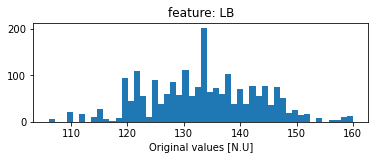

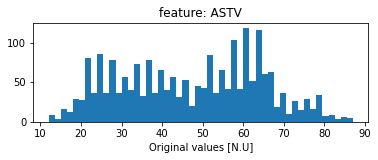

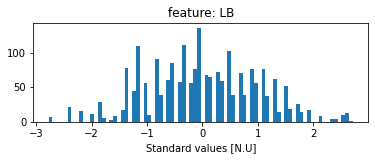

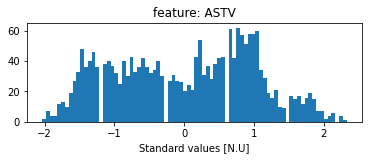

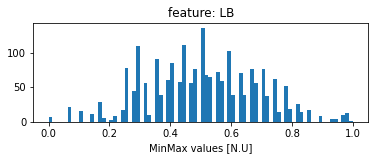

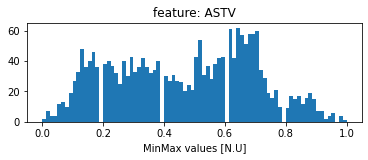

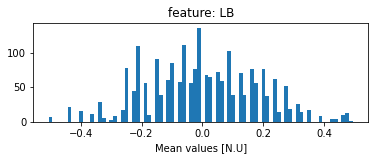

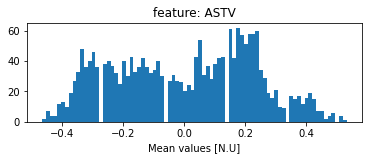

In [14]:
from clean_data import NSD
selected_feat = ('LB','ASTV')
scaler = NSD()
orig = scaler.fit_transform(CTG_features, selected_feat=selected_feat, flag=True)
nsd_std = scaler.fit_transform(CTG_features, mode='standard', selected_feat=selected_feat, flag=True)
nsd_norm = scaler.fit_transform(CTG_features, mode='MinMax', selected_feat=selected_feat, flag=True)
nsd_norm_mean = scaler.fit_transform(CTG_features, mode='mean', selected_feat=selected_feat, flag=True)

### Questions:
**Q4:** Explain why normalization is not useful when there are outliers with extremely large or small values.

### Answers:
**Q4:**

Normalization is not useful in that case because if we leave the outliers with the extreme values the normalization process will take them in count and they will be normalized to the extreme values as well (zero and one), and the distribution of the main values will shrink to a small range.

# Part II: Linear Classifiers

Finally, after all of the hard work we can now harvest the fruits (your functions from Part I) in order to do some proper machine learning!  

Note: It is recommended that you attend the second workshop for this part and use the notes in your homework folder.

In this assignment we will assume that our data is linearly separable and we will use logistic regression as our classification method. In other words, we choose a linear hypothesis class function . We would try to make the separation in the feature domain (i.e. our graph axes are the features) and we will have a multiclass problem.

For every sample (example as called in the lecture) we have two types of labels and we will deal only with one of them. Our goal is to learn the function that gets a sample as an input and returns a predicted value which is supposed to be the calss (label) that it belongs to. Our type of label will be `fetal_state`. Before we continue towards the "learning" part we will have another look at our data. Starting with our labels distribution.

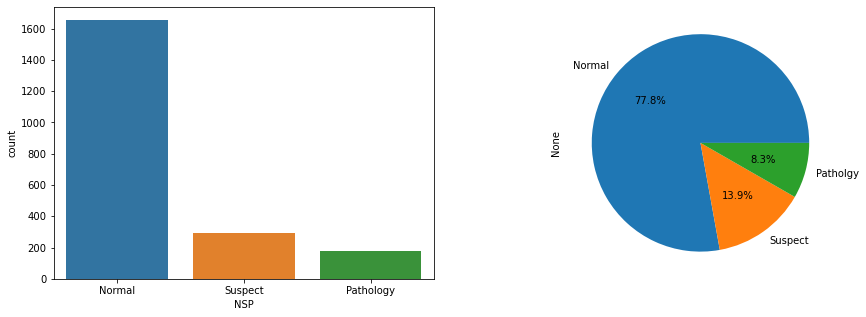

Normal samples account for 77.85% of the data.
Suspect samples account for 13.88% of the data.
Pathology samples account for 8.28% of the data.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# with seaborn:
g = sns.countplot(x = 'NSP', data = fetal_state, ax=axes[0])
g.set(xticklabels=['Normal','Suspect','Pathology'])
# with matplotlib
fetal_state.value_counts().plot(kind="pie", labels=['Normal','Suspect', 'Patholgy'], autopct='%1.1f%%', ax=axes[1])
plt.show()
idx_1 = (fetal_state == 1).index[(fetal_state == 1)['NSP'] == True].tolist()
idx_2 = (fetal_state == 2).index[(fetal_state == 2)['NSP'] == True].tolist()
idx_3 = (fetal_state == 3).index[(fetal_state == 3)['NSP'] == True].tolist()
print("Normal samples account for " + str("{0:.2f}".format(100*len(idx_1)/len(fetal_state))) + "% of the data.")
print("Suspect samples account for " + str("{0:.2f}".format(100*len(idx_2)/len(fetal_state))) + "% of the data.")
print("Pathology samples account for " + str("{0:.2f}".format(100*len(idx_3)/len(fetal_state))) + "% of the data.")

We can see that most of the CTG's were labeled as normal. Mostly, lables are made by professionals (in our case, doctors) based on the interpretation of the FHR and our job is to make the computer make the same decisions as a doctor would do but automatically. Now let's get the feeling of how well the features correlate with the labels and with one another. 

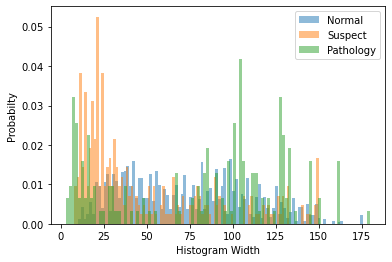

In [16]:
bins = 100
feat = 'Width'
plt.hist(CTG_features[feat].loc[idx_1], bins, density=True, alpha=0.5, label='Normal')
plt.hist(CTG_features[feat].loc[idx_2], bins, density=True, alpha=0.5, label='Suspect')
plt.hist(CTG_features[feat].loc[idx_3], bins, density=True, alpha=0.5, label='Pathology')
plt.xlabel('Histogram Width')
plt.ylabel('Probabilty')
plt.legend(loc='upper right')
plt.show()

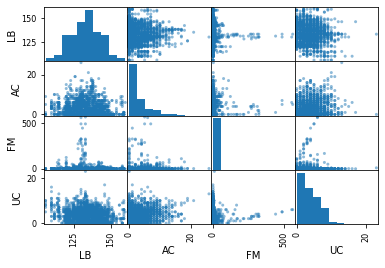

In [17]:
pd.plotting.scatter_matrix(CTG_features[['LB','AC','FM','UC']])
plt.show()

### Questions:
**Q5:** What information does feature-feature correlation provide?

### Answers:
**Q5:**

Feature-feature correlation provides the information about their linear dependence. Their dependence can 
If two features has high correlation we can ignore one of them during the learning.


Alright, we are pretty much done with data exploration. Now the learning part begins. As you saw in the tutorials, one of the most common and useful packages that Python has to offer in the learning field is `sklearn` package. The first thing you need to do after exploring your data is to divide it into 2 sets: `training set` and `test set`. As a rule of thumb, a typical split of your dataset is 80%, 20%  respectively. Later on we will also use validation set.
One of the most common linear classification models is logistic regression – abbreviated ‘LR’. We will use this model through our assignment from now on. 
Implement the function `pred_log` which is in the module `lin_classifier`. It should return a tuple of two elements. The first one is a vector of predicted classes and the other one is the weighting matrix (w) that should have the shape of (# of classes, # of features).

As you noticed, most of our data is labeled as "Normal" which means that our data is *imbalanced*. This is the reason why we *stratification* when we split out data to training and test sets. Stratification means that the split preserves the percentage of samples for each class.

In [18]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lin_classifier import *
orig_feat = CTG_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(CTG_features, np.ravel(fetal_state), test_size=0.2, 
                                                    random_state=0, stratify=np.ravel(fetal_state))
logreg = LogisticRegression(solver='saga', multi_class='multinomial', penalty='none', max_iter=10000)
y_pred, w = pred_log(logreg, X_train, y_train, X_test)
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Accuracy is: 88.03%
F1 score is: 78.32%


Hopefully, you got about 88% accuracy. Not bad! This is a better result comparing the naive classifier (prediciting a "Normal" label for every sample) that should have given us around 77% accuracy. Now we'll practice an interpretation of the results. As you saw in lecture 4, odds ratio can be applied on binary LR, and here we'll expand it to the multinomial (ovr) case. We want to explore how addition of +1 to a specific feature affect the 'Normal' labeling incidence. Implement the function `odds_ratio` under lin_classifier. The function inputs are weights (`w, x`) and the selected feature. Regarding the second argument, think which one fits - X_train or X_test and fill this argument accordingly. Choose one of the features as you wish and return both the `odds ratio` and the median `odd`.

*Hint:*
*First try to understand the relation between binary LR and one-vs-rest LR.*

In [19]:
selected_feat = 'LB'
# Change x to be either training or testing according to your decision
odds, ratio = odds_ratio(w, X_train, selected_feat=selected_feat)  # you have to fill the right X first

print(f'The odds ratio of {selected_feat} for Normal is {ratio}')
print(f"The odds to be labeled as 'Normal' is {odds}")

The odds ratio of LB for Normal is 0.9918548649503018
The odds to be labeled as 'Normal' is 55.31409280285855


### Question:
**Q6:** What is the meaning of your results? Explain the difference between odds_ratio and odds.

### Answers:
**Q6:**

Odds is the likelihood of a particular outcome - x. The formula is: p(x)/(1-p(x))
In our results the odds are 55.32 - the likelihood to get "Normal" is 55.32 which means that for every 55 "Normal" results, 1 will be from another class. 

Generally, odds ratio is the ratio between two odds. In our case, it is the ratio that represents how the odds change with one unit increase in a specific feature, while the other variables constant. If we increase the value of feature 'LB' by one unit the likelihood to get "Normal" is 55.32*0.99 ~ 55.32.

 Now let's see if normalization and standardization help us. Fill the next cell and print the accuracy and F1 of the model on the testing set after standardizng and training correctly. *Important notes*:

* Avoid information leakage!
* Do not apply the `NSD` methods on the labels. 
* Set the `flag` argument to `False` when using `NSD` methods.

In [20]:
# ------------------------Implement your code here:------------------------------
nsd_std_X_train = scaler.fit_transform(X_train, mode='standard', selected_feat=selected_feat, flag=False)
nsd_std_X_test = scaler.fit_transform(X_test, mode='standard', selected_feat=selected_feat, flag=False)

y_pred, w = pred_log(logreg, nsd_std_X_train, y_train, nsd_std_X_test)
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")
# --------------------------------------------------------------------------------

Accuracy is: 90.14%
F1 score is: 80.84%


You can now choose one of the modes and stick to it. Let's visualize our learned parameters. Use your chosen weight matrix as an input to the function `w_no_p_table` in the next cell.

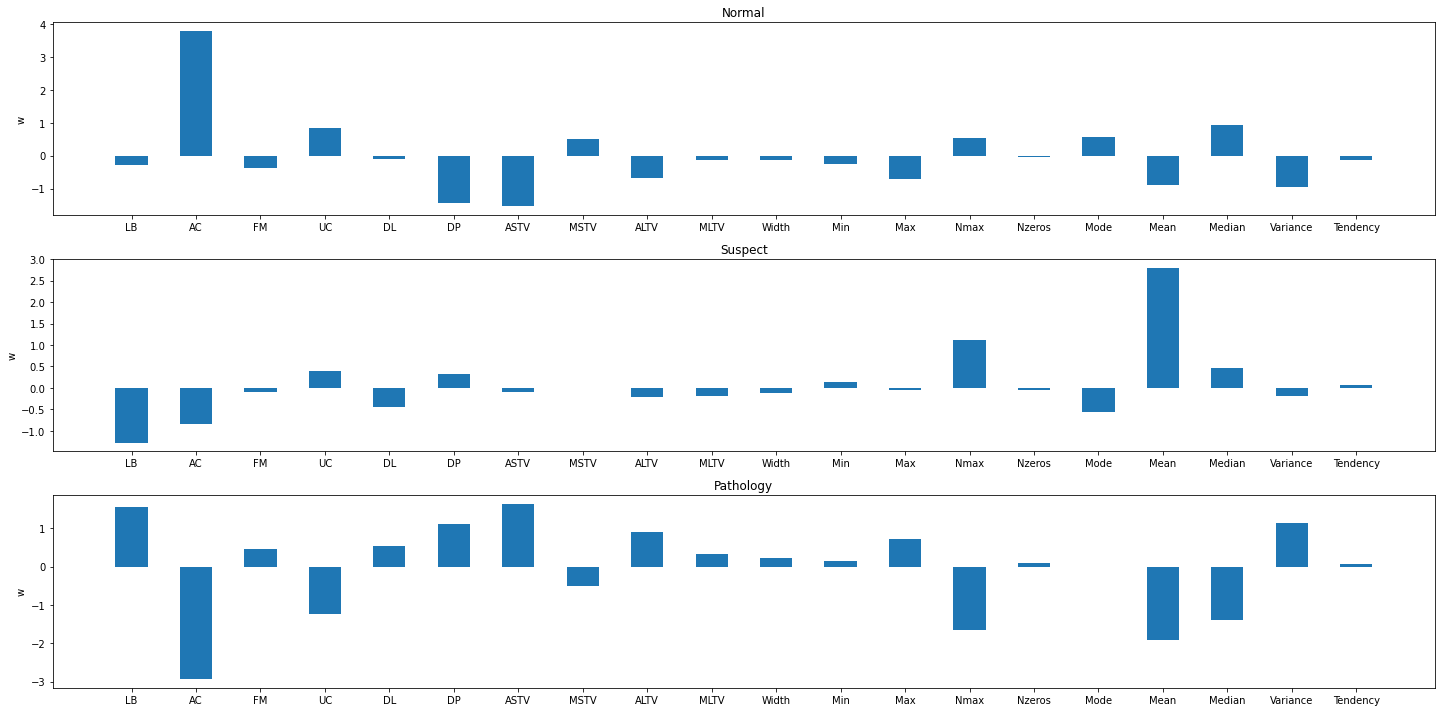

In [21]:
# Change input_mat to your weight matrix from the cell above
w_no_p_table(w,orig_feat)

### Questions:
**Q7:** Mention one advantage and one limitation of using cross entropy.


**Q8:** By selecting one feature at a time and compare their learned weights by looking at plots we had, what can you tell about the weights relations? Why does it happen? **Hint:** notice the sign of the weights and remember that an exponent is a monotonic function.

### Answers:
**Q7:**

Atvantage of using cross entropy - it minimizes the loss between two probability distributions, predicted and known. We need to know that information to train the model.

Limitation of using cross entropy - The function has to be convex so it won't have multiple minima.

**Q8:**

We can tell that there is an inverse correlation between the class "Normal" and the classes "Suspect" & "Pathology" for most of the features (13 features), other feature weights has correlation between "Normal" and "Suspect" or "Pathology".

The weights sign shows us the correlation between the odds (of a class) and the feature. It means that for most of the time - while the odds for "Normal" are getting higher, the odds for other classes lowering.
For exemple, if we look at the 'AC' feature, we can see clearly that if the value (x) is ascending then the odds for the class to be "Normal" ascending as well, while the odds for the class to be "Suspect" or "Pathology" descendind, and vice versa.


Ok, now let's recall that in the lecture you saw that accuracy is not always our best measure. Sensitivity and specificity can be much more informative and important mostly. The choise to train a model to have better results in sensitivity aspect rather than specificty or vice versa depends on our application.

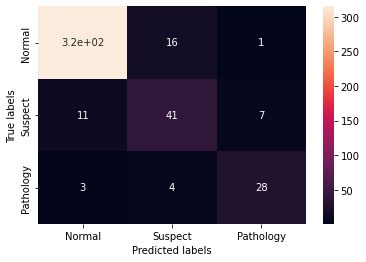

In [22]:
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
    ax.set(ylabel='True labels', xlabel='Predicted labels')
    plt.show()

### Questions:
**Q9:** What do you think is more important to us with this data? What is the clinical risk/cost for False Positive (FP) and False Negative (FN)?

### Answers:
**Q9:** 

We think that sensitivity is more important to us. Sensetivity is calculated as the ratio of True Positive (TP) and all originally positive results (TP+FN).

The clinical cost of False Negative is that a patient with a disease won't know that he is sick and he won't be treated and  there will major repercussions and can lead to fatal outcome.

The clinical cost of False Positive is unnecessary procedures, treatments and anxiety that the patient will feel. 

So, now we will try to handle one of the main issues in learning which is called **overfitting** and one way to deal with it is called **regularization**.

There are several types of regularizations and in this assignment we will expirience two of them:

1) Loss regularization.

2) Validation.

The loss function is a function that takes the predicted values and the labels and *measures* how "close" they are to each other. Our demand is that this "distance" (metric) would be as low as possible. In addition to it, we can add more "demands" that we can represent by mathematical terms. For example, we can demand that the number of coefficients won't get to large or we can try to restrict their values. A more physical example is a demand that our signal has to be smooth. When we try to minimize the new loss function we actually try to find the result which is the comprimise of our demands. We can also "favour" one demand over another using **regularization parameters**.

You saw in the lecture "demands" on the learned weights and represented those demands mathematically using $ L_1 $ and $ L_2 $ norms. The regularization parameter was denoted as $\lambda$ (please notice that sometimes it is common to use the notation of $ c $ where $\lambda = c^{-1}$). Now it's your turn to become artists! Change and/or add arguments to *LogisticRegression* class in the next cell and perform learning using two regularizations: $ L_1 $ and $ L_2 $. Examine your results using the confusion matrix as we did before. Tune your regularization parameter until you get a result that you think is reasonable and that it brings the sensitivity/specificity (depending on what you chose before) to the maximum. 

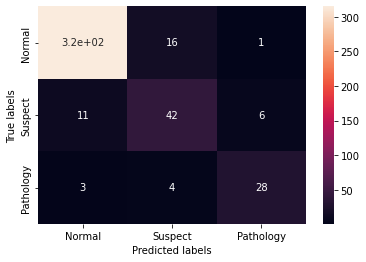

Accuracy is: 90.38%
F1 score is: 81.58%


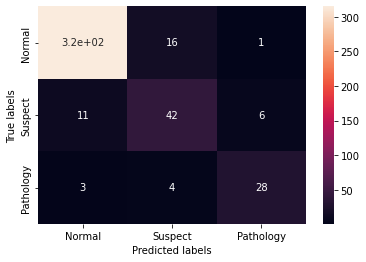

Accuracy is: 90.38%
F1 score is: 81.58%


In [23]:
#--------------------------------------------- Implement your code here:----------------------------------------------------------
lmbda = 0.34
logregL1 = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l1', C = 1/lmbda, max_iter=10000)
logregL2 = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l2', C = 1/lmbda, max_iter=10000)

y_pred1, w1 = pred_log(logregL1, nsd_std_X_train, y_train, nsd_std_X_test)
y_pred2, w2 = pred_log(logregL2, nsd_std_X_train, y_train, nsd_std_X_test)

cnf_matrix1 = metrics.confusion_matrix(y_test, y_pred1)
ax = plt.subplot()
sns.heatmap(cnf_matrix1, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred1))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred1, average='macro'))) + "%")


cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
ax = plt.subplot()
sns.heatmap(cnf_matrix2, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred2))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred2, average='macro'))) + "%")
#----------------------------------------------------------------------------------------------------------------------------------

Now that you are happy with your results, let's compare the coefficients of the two norms. Choose two weightning matrices (one calculated using $ L_2 $ and the other calculated using $ L_1 $) and use them as inputs in `w_all_tbl` function. This function sorts the weights according to their $ L_2 $ norm (so the first argument has to be the matrix of $ L_2 $) and compares them to $ L_1 $.

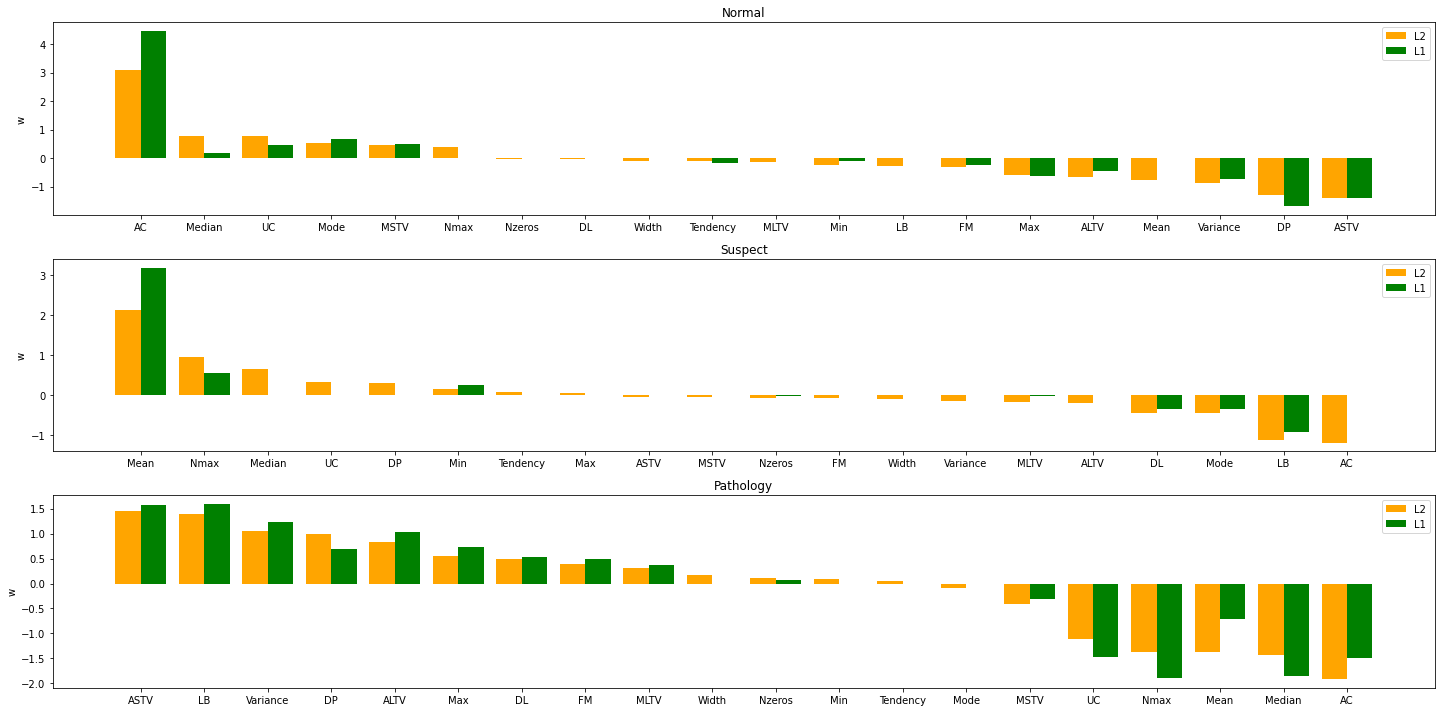

In [24]:
w_all_tbl(w2, w1, orig_feat)

Notice that the features are ordered differently because they are sorted according to $ L_2 $ values.

### Questions:
**Q10:** What is the difference that you can see when plotting $ L_1 $ vs. $ L_2 $? Could you expect it ahead?

**Q11:** Why is LASSO coupled with feature selection?

### Answers:
**Q10:**

We see in the plot that with some features has zero weight when the penalty is L1, but has some weight when the penalty is L2. We could expect it ahead because we know that L1 tends to reduce the irrelevente feature weights to zero whereas L2 tends to reduce weights evenly.

**Q11:**

LASSO (L1) coupled with feature selection because L1's penalty is absolute values, it has a discontinuity at 0 which causes subtraction results that cross 0 to become zeroed out.

Now we will use a method that help us to choose what we call *hyperparameters* of the model. This is also a method of regularization and it is called **validation**. There are several types of validation and here we will use *stratified K-fold cross validation*. The hyperparmeters that we would like to choose are the norms that we want to train with and the regularization parameter. Again, we use stratification for the folds to prevent biased learning.

Implement the function `cv_kfold` in `lin_classifier` module. We will use `X_train` as our training set that will be iteratively divided into $ K-1 $ training sets and one validation set. **Notice:** choose wisely where to apply `NSD` fit and transformation to avoid information leakage in every iteration. In this function you should build a list of dictionaries called `validation_dict` where each element in the list contains a dictionary with 4 keys name: `C, penalty, mu and sigma`. For every pair of parameters (`C and penalty`) you will run $ K $ validations and `mu and sigma` will be calculated as the average loss and standard deviation over $ K $ folds respectively. Use the function `log_loss` from `sklearn.metrics` that was already imported in `lin_classifier`. One more thing, you will have to implement a simple modification to `pred_log` function using the `flag` argument. When this flag is set to `True`, the function should return the probabilities of the classes and not the classes themselves. This is the output that `log_loss` function expects to get.
In the next cell, build a list called `C` that has up to 6 regularization parameters (different lambda). Set `K` as number of folds. Choose `mode` for `NSD` and set `penalty = ['l1,'l2]`. Then, excecute the function `cv_kfold` which should return the dictionary of dictionaries named `val_dict` that will be used in the following cell.
This function might take a while to perform depending on $ K $ and the number of regularization parameters you will choose.

In [25]:
#-------------------------------------Implement your code here:----------------------------------------
C = np.array([0.001, 0.01, 1, 10, 100, 1000])
K = 5 
penalty = ['l1', 'l2']
mode = 'standard'
val_dict = cv_kfold(X_train, y_train, C, penalty, K, mode)
#------------------------------------------------------------------------------------------------------

Let's visualize your results:

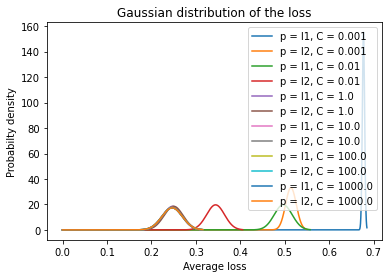

In [26]:
import scipy.stats as stats
for d in val_dict:
    x = np.linspace(0, d['mu'] + 3 * d['sigma'], 1000)
    plt.plot(x,stats.norm.pdf(x, d['mu'], d['sigma']), label="p = " + d['penalty'] + ", C = " + str(d['C'])) 
    plt.title('Gaussian distribution of the loss')
    plt.xlabel('Average loss')
    plt.ylabel('Probabilty density')

plt.legend()
plt.show()

You can now choose parameters according to the results. Explain why did you choose these hyperparmeters.

### Answer:  We chose the hyperparmeters p=l1 and C=10, because it's the minimal average loss that we saw on the plot.

Now you can train you model with the **full training set**.

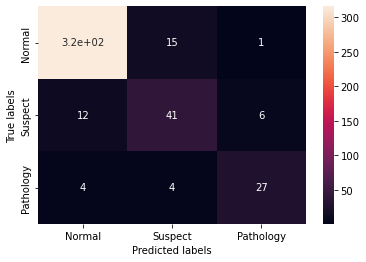

Accuracy is: 90.14%
F1 score is: 80.78%


In [27]:
#-------------------------------------Implement your code here:----------------------------------------
logregL1_final = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', C = 10, max_iter=10000)
y_pred_final, w_final = pred_log(logregL1_final, nsd_std_X_train, y_train, nsd_std_X_test)

cnf_matrix_final = metrics.confusion_matrix(y_test, y_pred_final)
ax = plt.subplot()
sns.heatmap(cnf_matrix_final, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred_final))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred_final, average='macro'))) + "%")
#------------------------------------------------------------------------------------------------------

Great job! So as you can see results did get better but not by that much but you got the feeling how to handle with data, what are the basics of learning and what are the real effects and applications of what you saw in the lectures. Now, one last thing: A possible reason for the poor improvements is that our data is probably not linearly separable and we used a linear classifier. There are two basic approaches for this kind of problem:
The first one is to use non-linear classifier and the second one is to perform a transformation on our data so it will become linearly separable in another space. Here is an example of 2D data that can also visualize the problem and the second approach:

<img src="https://sthalles.github.io/assets/fisher-ld/feature_transformation.png" width=600 align="center"> 

As you can see, the features were non-linearly transformed simply by squaring each feature.

### Questions:
**Q12:** Look at the data. Why was it reasonable to expect that squaring each feature would make the data linearly sperable?

**Q13:** Sugest another non-linear transformation (where **both** new axes are a function of **both** $(x_1,x_2)$ that would make the data linearly seperable so that the line that seperates the two data types will be perpendicular to one of the new axes. Write the new two features (axes) **explicitly** as a funciton of $ (x_1,x_2) $. Use LaTex to write mathematical operations.

### Answers:
**Q12:** 

It is reasonable to expect that squaring each feature would make the data linearly sperable because their distribution is circular and concentric. When we are squaring the values and plot them we get: x2=sqrt(R^2 - x1^2) - a linear equation. We can see that the red plot avarage radius is smaller then the blue plot avarage radius so when plotting them on the new plot we get two linearly separated groups.

**Q13:**

Another non-linear transformation that would make the data linearly seperable is converting the elements to polar coordination: R = sqrt(x1^2+x2^2), teta = tan(x2/x1).
For the red plot and the blue plot, this transformation gives us parallel values because R is approximately constant for every teta in each color.


Finally, just to get the feeling of better results when we go non-linear, let's try the random forest classifier. All you have to do is just choose one of the modes of the `NSD` tranformation method and see if you got better results:

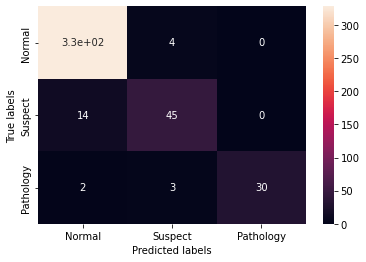

Accuracy is: 94.60%
F1 score is: 90.14%


In [28]:
from sklearn.ensemble import RandomForestClassifier as rfc
mode = 'standard' # choose your method
clf = rfc(n_estimators=10)
clf.fit(scaler.fit_transform(X_train, mode=mode), y_train)
y_pred = clf.predict(scaler.transform(X_test, mode=mode))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal', 'Suspect', 'Pathology'],
            yticklabels=['Normal', 'Suspect', 'Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

That's all folks!